<a href="https://colab.research.google.com/github/Angel-dash/Abstractive-Text-Summarization/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uncomment the code below if you are running on google colab
If you are running the code on the google colab then you must have the data set on your google drive. Link to the dataset where you can download it form https://drive.google.com/file/d/1CAK0Cj1kNgoZ0FRxwwCflbh-1-hKDPoK/view?usp=sharing



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [2]:
#!unzip /content/drive/MyDrive/DL/data.zip # Comment out for niranjan's
!unzip /content/drive/MyDrive/MiniProjectdata/amazon.zip #comment out for Angel's



Archive:  /content/drive/MyDrive/MiniProjectdata/amazon.zip
replace Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Reviews.csv             y

replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: database.sqlite         y

replace hashes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: hashes.txt              


In [3]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import textwrap
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#data_train=pd.read_csv('/content/cnn_dailymail/train.csv')
#data_test=pd.read_csv('/content/cnn_dailymail/test.csv')
#data_validation=pd.read_csv('/content/cnn_dailymail/validation.csv')
data=pd.read_csv('/content/Reviews.csv',nrows=100000)

Data preprocessing

In [5]:
#data = pd.concat([data_train, data_test, data_validation ])
df = data

In [6]:
new_df=df.sample(25000)

In [7]:
new_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2864,2865,B002BB8POY,A3N197JTY971TZ,"J. Le Blanche ""Novo-Andina""",5,8,5,1269561600,Safety Instructions for coca tea,High quality coca products do not have a paper wraps since they can harbor dirt and bacteria and the printing ink can change or contaminate the delicate flavor of the tea bags.<br />Organic coca t...
80002,80003,B000JFKU9W,A339F4I8GBN3H3,"LaughingLion ""I am Lion, read me review!""",0,0,5,1346284800,Perfect,"One of the the things I hate about buying snack food is most companies can not get the right amount of salt on to foods.<br /><br />That was not a problem here.<br /><br />Great flavor, nice sized..."
74864,74865,B0026RQTGE,A2Z054F2OGR62S,B. Young,0,0,5,1329696000,Great treat to keep teeth healthy,One greenie a day after dinner helps our dog's teeth stay cleaner. Also we brush daily with the salmon oil infused grain alcohol gel product. That works so much better than the enzymatic toothpa...


In [8]:
new_df.shape

(25000, 10)

Checking for Null values


In [9]:
new_df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               1
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

Checking for duplicates


In [10]:
new_df.duplicated(subset=['Text']).sum()

937

In [11]:

new_df=new_df.drop_duplicates(subset=['Text'])
new_df.shape

(24063, 10)

In [12]:

new_df.duplicated(subset=['Text']).sum()


0

new_df['Text'][:10]

In [13]:
new_df['Text'] = new_df['Text'].str.lower()
new_df['Summary'] = new_df['Summary'].str.lower()

new_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2864,2865,B002BB8POY,A3N197JTY971TZ,"J. Le Blanche ""Novo-Andina""",5,8,5,1269561600,safety instructions for coca tea,high quality coca products do not have a paper wraps since they can harbor dirt and bacteria and the printing ink can change or contaminate the delicate flavor of the tea bags.<br />organic coca t...
80002,80003,B000JFKU9W,A339F4I8GBN3H3,"LaughingLion ""I am Lion, read me review!""",0,0,5,1346284800,perfect,"one of the the things i hate about buying snack food is most companies can not get the right amount of salt on to foods.<br /><br />that was not a problem here.<br /><br />great flavor, nice sized..."
74864,74865,B0026RQTGE,A2Z054F2OGR62S,B. Young,0,0,5,1329696000,great treat to keep teeth healthy,one greenie a day after dinner helps our dog's teeth stay cleaner. also we brush daily with the salmon oil infused grain alcohol gel product. that works so much better than the enzymatic toothpa...


Converting to lower case

In [14]:
#removing html tags
import re
def remove_html_tags(text):
    if isinstance(text, str):
        pattern = re.compile('<.*?>')
        return pattern.sub(r'', text)
    else:
        return text

In [15]:
new_df['Text'] = new_df['Text'].apply(remove_html_tags)

new_df['Summary'] = new_df['Summary'].apply(remove_html_tags)

In [16]:
new_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2864,2865,B002BB8POY,A3N197JTY971TZ,"J. Le Blanche ""Novo-Andina""",5,8,5,1269561600,safety instructions for coca tea,high quality coca products do not have a paper wraps since they can harbor dirt and bacteria and the printing ink can change or contaminate the delicate flavor of the tea bags.organic coca tea bag...
80002,80003,B000JFKU9W,A339F4I8GBN3H3,"LaughingLion ""I am Lion, read me review!""",0,0,5,1346284800,perfect,"one of the the things i hate about buying snack food is most companies can not get the right amount of salt on to foods.that was not a problem here.great flavor, nice sized packets."
74864,74865,B0026RQTGE,A2Z054F2OGR62S,B. Young,0,0,5,1329696000,great treat to keep teeth healthy,one greenie a day after dinner helps our dog's teeth stay cleaner. also we brush daily with the salmon oil infused grain alcohol gel product. that works so much better than the enzymatic toothpa...


In [17]:
#removing punchuation


import string
string.punctuation
exclude = string.punctuation
def remove_punc(text):
    if isinstance(text, str):
        return ''.join(ch for ch in text if ch not in exclude)
    else:
        return str(text)  # Convert non-string data to string

In [18]:
new_df['Text'] = new_df['Text'].apply(remove_punc)

new_df['Summary'] = new_df['Summary'].apply(remove_punc)

In [19]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
new_df['Text'] = new_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
new_df['Summary'] = new_df['Summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
new_df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2864,2865,B002BB8POY,A3N197JTY971TZ,"J. Le Blanche ""Novo-Andina""",5,8,5,1269561600,safety instructions coca tea,high quality coca products paper wraps since harbor dirt bacteria printing ink change contaminate delicate flavor tea bagsorganic coca tea bags contain preservatives additives therefore must prope...


In [22]:
#!pip install contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [23]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
#call the function
cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [25]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [26]:
df['Summary'] = df['Summary'].astype(str)

In [27]:
#call the function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [28]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [29]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

In [30]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

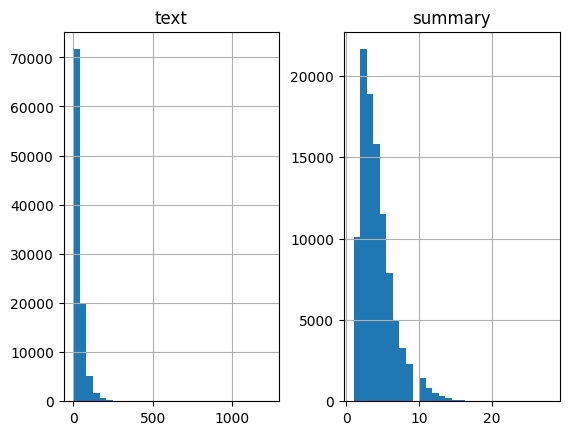

In [31]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

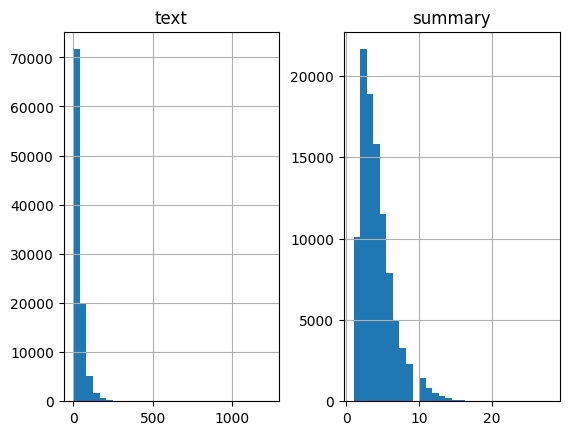

In [32]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [33]:
max_len_text=30
max_len_summary=10

In [34]:
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

0.9421608367112045


In [35]:
cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [36]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [37]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [39]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 63.80591117433223
Total Coverage of rare words: 2.565380716446803


In [40]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1


In [41]:
x_voc

9161

In [42]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [43]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.95464755588833
Total Coverage of rare words: 4.714142807341952


In [44]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [45]:
y_voc

2249

In [46]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(49264, 49264)

In [47]:
type(y_tr)

numpy.ndarray

In [48]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [49]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

LSTM model building

In [50]:
from keras import backend as K
K.clear_session()
latent_dim = 300
embedding_dim=200 #Keeping latent dimension to 300 and introducing embedding dimension of 100 to reduce the number of parameters of the model
#condider chaging the latent_dim to smaller value such as 100 or 300
#also adding a seperate embedding_dim can help to reduce the compleixity of the model

In [51]:
#encoder

encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#enc_emb = shared_emb_layer(encoder_inputs)

In [62]:
# Encoder with Bidirectional LSTM layers
encoder_bilstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.4))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bilstm1(enc_emb)

encoder_bilstm2 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.4))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bilstm2(encoder_output1)

encoder_bilstm3 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm3(encoder_output2)
'''#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
'''

'#LSTM 1\nencoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.4)\nencoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)\n\n#LSTM2\nencoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.4)\nencoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)\n\nencoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)\nencoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)\n'

In [63]:
#decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#dec_emb = shared_emb_layer(decoder_inputs)

In [66]:
import tensorflow as tf
# Concatenate forward and backward states for each state component
initial_state = [tf.concat([forward_h2, backward_h2], axis=-1),  # Concatenate hidden states
                  tf.concat([forward_c2, backward_c2], axis=-1)]  # Concatenate cell states

# Now, pass the concatenated initial state
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(dec_emb, initial_state=initial_state)


In [67]:
#pip install attention_keras
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs,verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [68]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

In [69]:
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [70]:
#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)


In [71]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              916100    ['input_1[0][0]']             
                                                                                                  
 bidirectional_9 (Bidirecti  [(None, 30, 600),            962400    ['embedding[0][0]']           
 onal)                        (None, 300),                                                        
                              (None, 300),                                                        
                              (None, 300),                                                    

In [72]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy') #using Adam optimizer instead of rms for better performance and efficieny in terms of speed

In [73]:
#using Early stoppage to stop the training of the model once the validation increasers
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Specify the path to save the model
# You can change 'model.h5' to your preferred file name
model_path = '/content/drive/MyDrive/savedModels'

# Create a ModelCheckpoint callback
#checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=False, save_freq=3)
checkpoint = ModelCheckpoint(filepath=model_path + "model_epoch{epoch}.h5", monitor='val_loss', verbose=1, save_best_only=False, save_freq='epoch', period=3)
# Add the callback to your model's fit method
history=model.fit(
    [x_tr,y_tr[:,:-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
    epochs=20,callbacks=[checkpoint,es],
    batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/20
189/189 [==============================] - 191s 866ms/step - loss: 2.5339 - val_loss: 2.1828
Epoch 2/20


In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [ ]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

In [ ]:
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

In [ ]:
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [ ]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

In [ ]:
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
    print("\n")